Install Libraries

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, accuracy_score, median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import RFECV
import pickle
from sklearn.inspection import partial_dependence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Load Dataset

In [103]:
generalStats_pos = pd.read_csv('E:/Inzynierka/generalStats_pos - generalStats_pos.csv')

Data cleaning

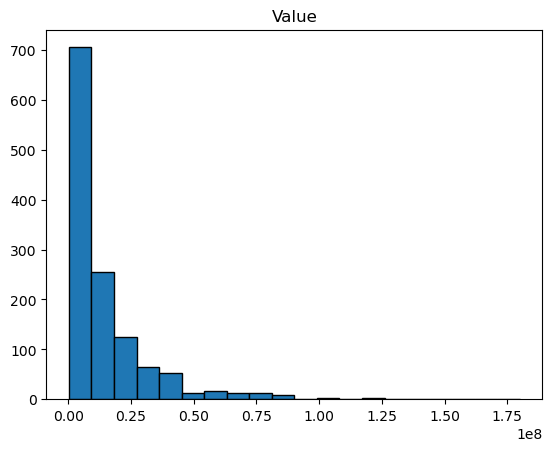

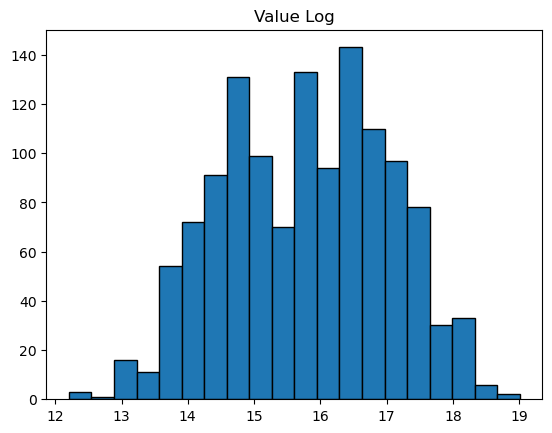

In [104]:
generalStats_pos['value_log'] = generalStats_pos['value'].apply(lambda x: math.log(x))
generalStats_pos = generalStats_pos.dropna()
sorted_data = np.sort(generalStats_pos['value'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value')
plt.show()

sorted_data = np.sort(generalStats_pos['value_log'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value Log')
plt.show()

In [105]:
def calculate_revised_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    msle = mean_squared_log_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2,
        "MAPE": mape,
        "MSLE": msle,
        "Median AE": median_ae
    }

In [106]:
X = generalStats_pos.iloc[:, 3:-2]
y = generalStats_pos.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [107]:
model = LinearRegression()
model.fit(X_train,y_train)
score = model.score(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [108]:
estimated_value_log = []
for i in range(0,len(generalStats_pos)):
    player_data = generalStats_pos.iloc[i,:].to_frame().transpose()
    player_data = (player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))

In [109]:
%%capture
generalStats_pos_local = generalStats_pos.copy()
estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

                     Player      value  estimated_value          diff  \
39            Mohamed Salah   65000000     274229112.54 -209229112.54   
10          Martin Ødegaard   90000000     256347568.19 -166347568.19   
0            Erling Haaland  180000000     333008463.29 -153008463.29   
1           Vinicius Júnior  150000000      45648674.06  104351325.94   
2               Bukayo Saka  120000000     215825551.78  -95825551.78   
7         Federico Valverde  100000000      22435792.98   77564207.02   
15        Eduardo Camavinga   85000000      17264261.40   67735738.60   
5                     Pedri  100000000      32944218.74   67055781.26   
17               Rúben Dias   80000000      15297112.50   64702887.50   
12                     Gavi   90000000      28348461.53   61651538.47   
8                Harry Kane   90000000     151145796.32  -61145796.32   
34             Éder Militão   70000000       9342543.17   60657456.83   
33            Ronald Araújo   70000000       966375

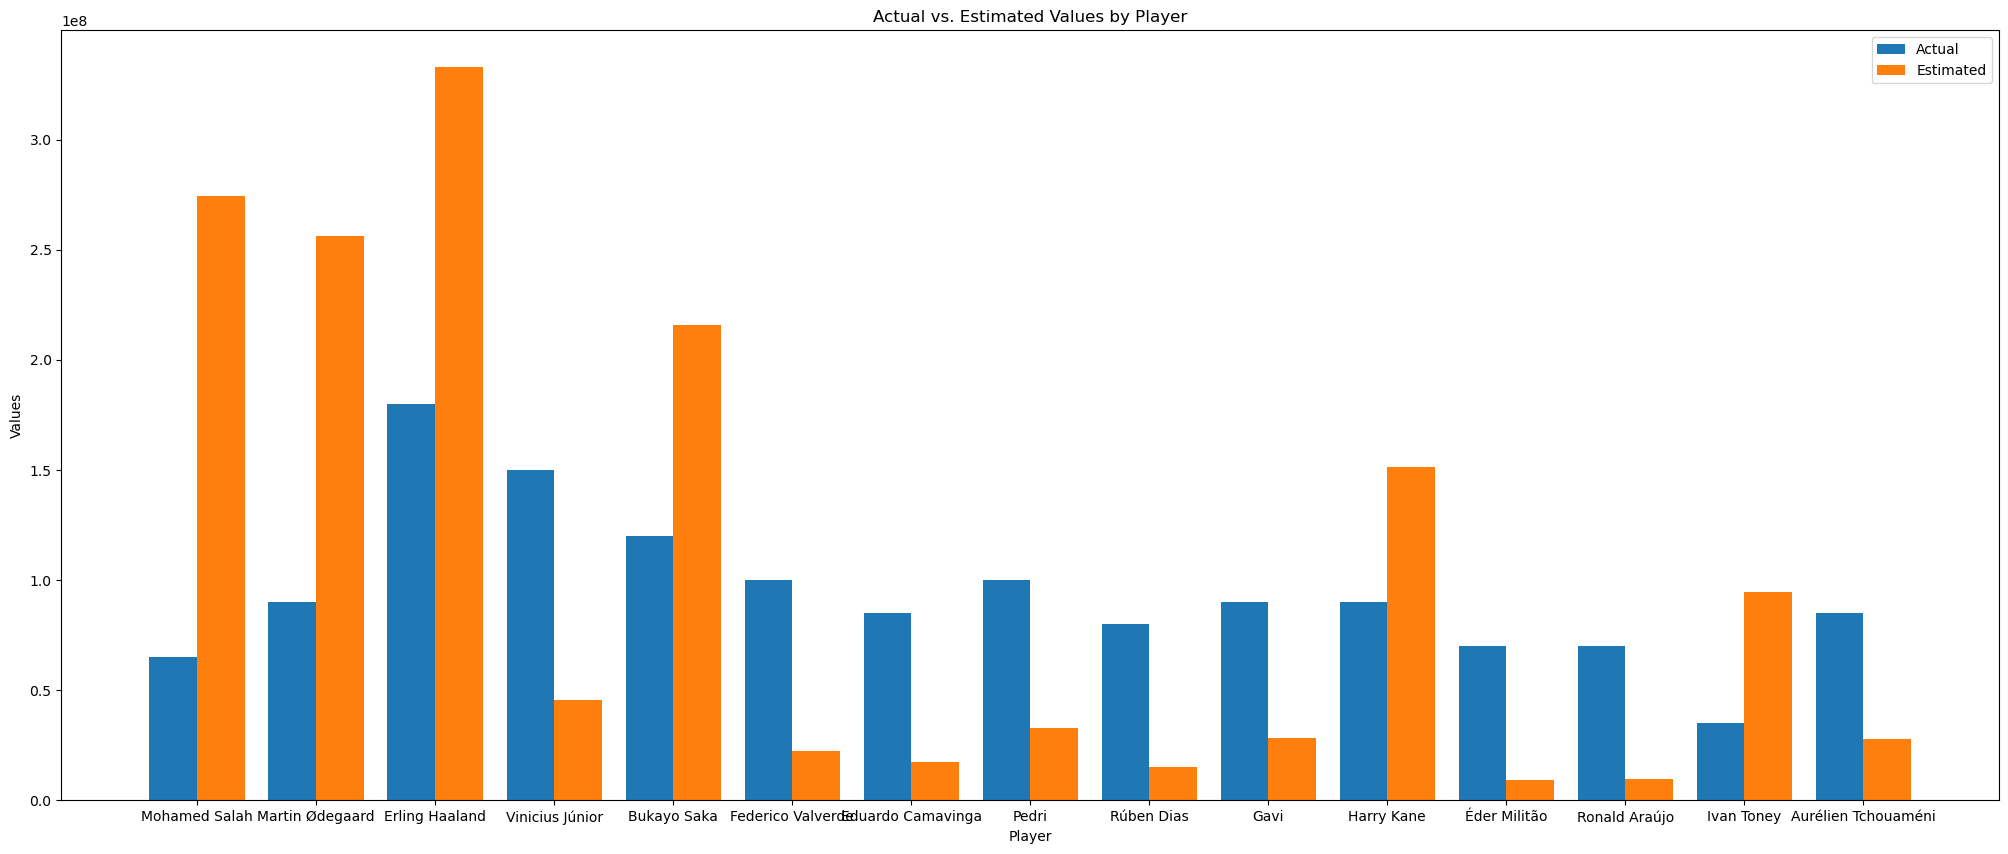

In [110]:
generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()

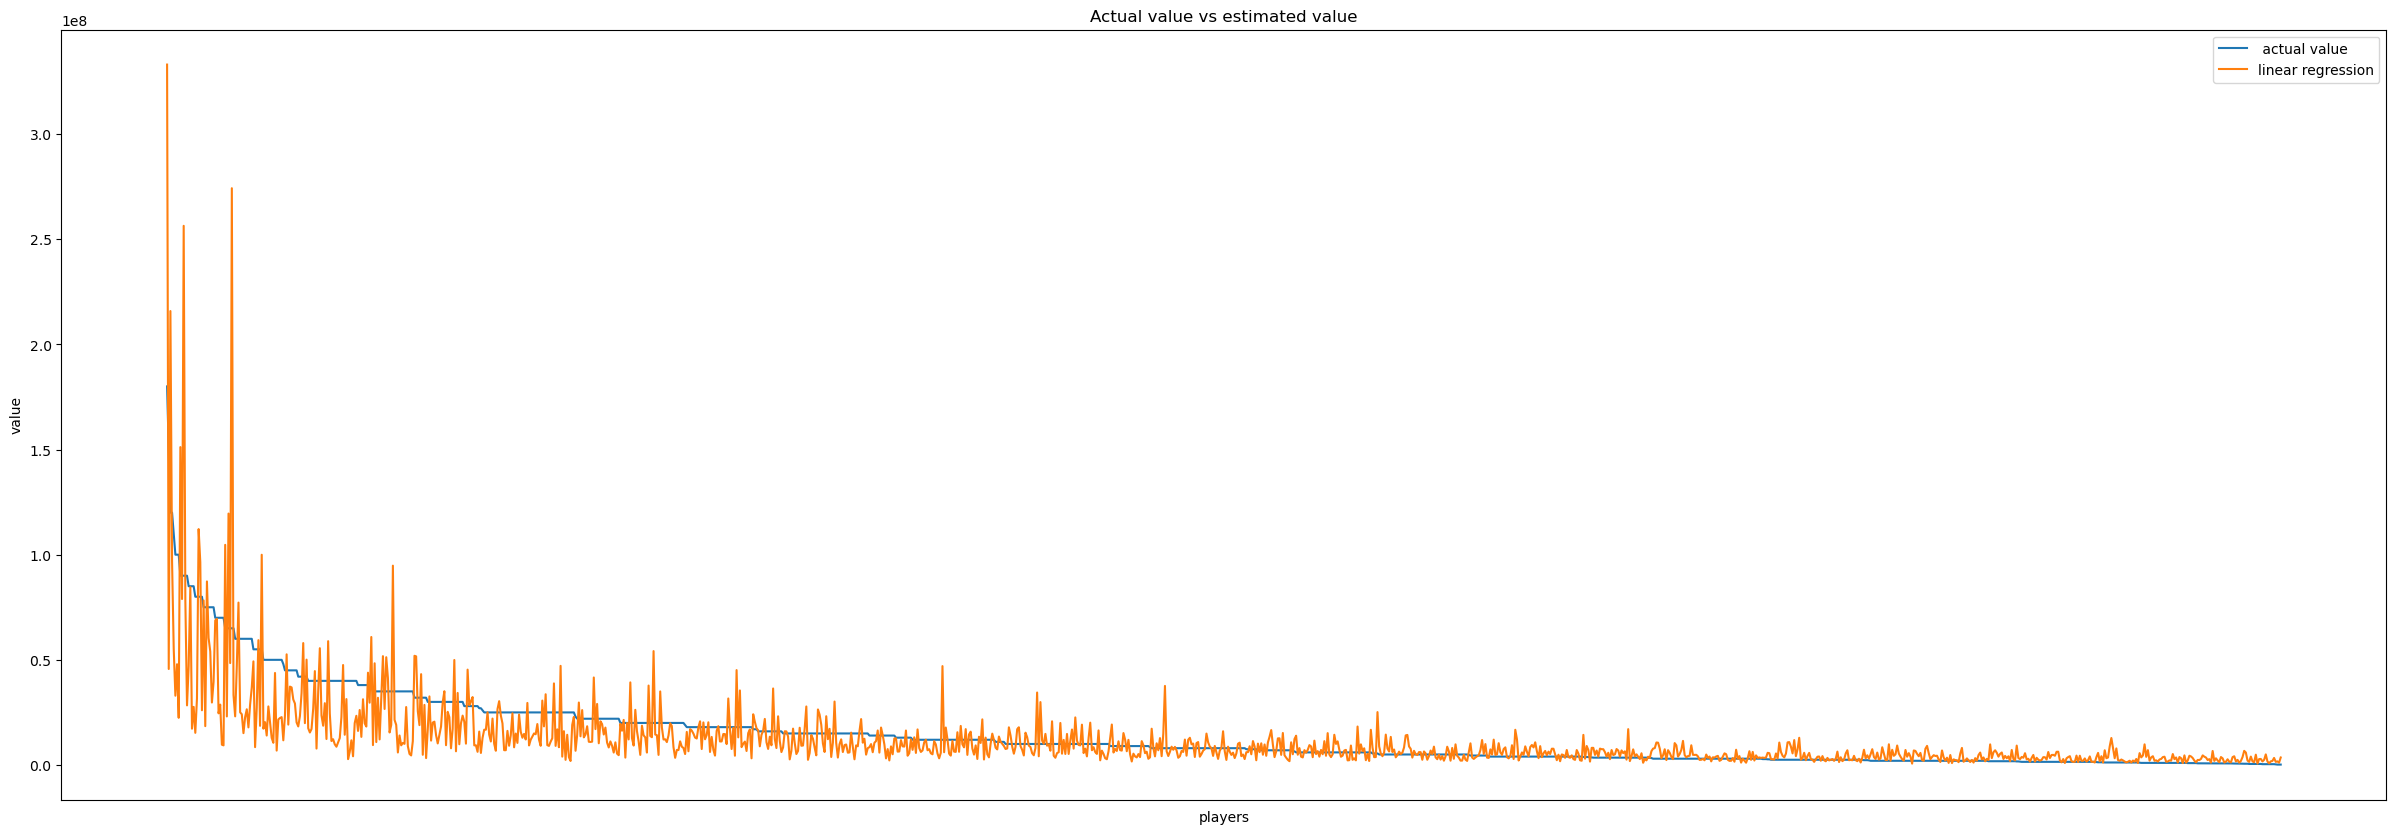

In [111]:
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='linear regression')


plt.legend()
plt.show()

In [112]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.6664571955212336, 'MSE': 0.7202284154846709, 'RMSE': 0.8486627218658016, 'R^2': 0.5442974179148088, 'MAPE': 4.3417189739763, 'MSLE': 0.002703105912089382, 'Median AE': 0.5335741263278813}


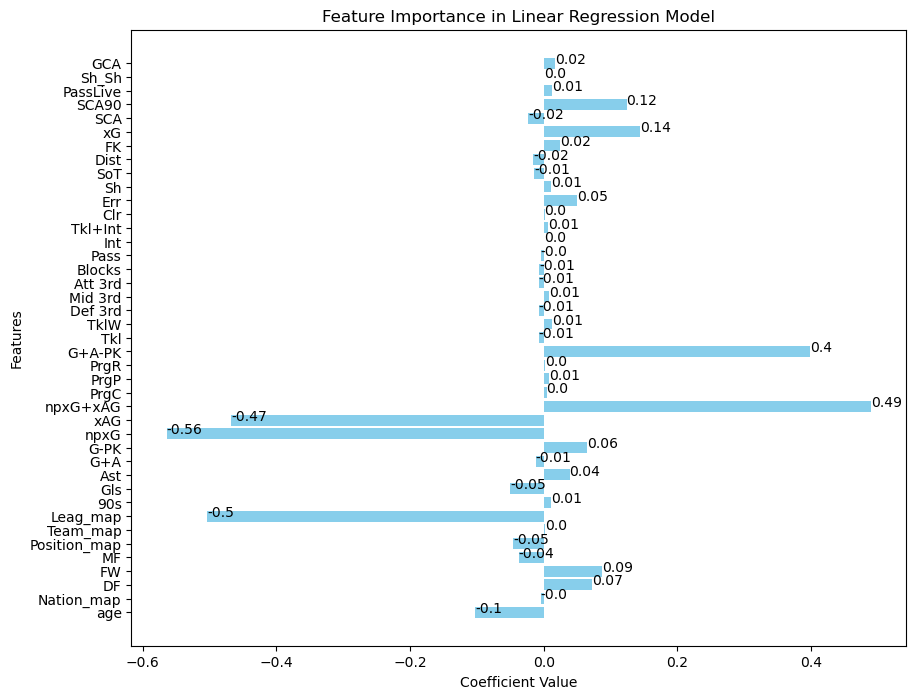

In [113]:

coefficients = model.coef_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = generalStats_pos.iloc[:, 3:-2].columns.tolist()

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Linear Regression Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

RFE on Linear Regression

In [115]:



estimator = LinearRegression()
selector = RFECV(estimator, cv=5)
selector = selector.fit(X_train, y_train)

print("Suggested number of features: %d" % selector.n_features_)
print("Selected features: %s" % selector.support_)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



Suggested number of features: 35
Selected features: [ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True False False  True False  True  True  True  True  True  True
  True  True  True False  True]


Which features performs the best

In [116]:
selected_fetures = []
keys = generalStats_pos.iloc[:, 3:-2].keys()
for i in range(0,len(selector.support_)):
    if selector.support_[i] == True:
        selected_fetures.append(keys[i])
print(selected_fetures)
print(len(selected_fetures))
np.save('E:/Inzynierka/X_train_selected_lnr.npy',X_train_selected )

['age', 'Nation_map', 'DF', 'FW', 'MF', 'Position_map', 'Leag_map', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'G+A-PK', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Blocks', 'Tkl+Int', 'Err', 'Sh', 'SoT', 'Dist', 'FK', 'xG', 'SCA', 'SCA90', 'PassLive', 'GCA']
35


Fit the model 

In [117]:
model = LinearRegression()
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

print('Score: ', score)

Score:  0.5928385253902011


In [118]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.6651431954584246, 'MSE': 0.7190386313051921, 'RMSE': 0.8479614562615403, 'R^2': 0.545050217597598, 'MAPE': 4.331906146476637, 'MSLE': 0.0026986669135615282, 'Median AE': 0.5343663114154733}


In [119]:
estimated_value_log = []
for i in range(0,len(generalStats_pos)):
    player_data = generalStats_pos.iloc[i,:].to_frame().transpose()
    player_data = selector.transform(player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))
    

In [120]:
print(player_data)

[[20 10 0 1 1 4 3 1.5 0 0 0 0 0.5 0.0 0.5 4 3 0.0 3.0 3.0 2.0 1.0 0.0 2.0
  4.0 0.0 4.0 1.0 11.8 0.0 0.5 1.0 0.68 1.0 0.0]]


In [121]:
%%capture
generalStats_pos_local = generalStats_pos.copy()
estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

In [122]:

print('---------------------------------------------------------------------------')
print('50 most overvalued players')
overvalued_50 = generalStats_pos_local[['Player','value','value_log','estimated_value','diff']].nlargest(n=50,columns = 'diff')
print(overvalued_50)
print('-----------------------------------------------------------------------')
print('50 most undervalued players')
undervalued_50 = generalStats_pos_local[['Player','value','value_log','estimated_value','diff']].nsmallest(n=50,columns = 'diff')
print(undervalued_50)
print('---------------------------------------------------------------------------')
generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])
print('50 best valued players')
bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)

print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))

---------------------------------------------------------------------------
50 most overvalued players
                    Player      value  value_log  estimated_value         diff
1          Vinicius Júnior  150000000      18.83      38499944.88 111500055.12
7        Federico Valverde  100000000      18.42      25075987.96  74924012.04
15       Eduardo Camavinga   85000000      18.26      17175207.64  67824792.36
5                    Pedri  100000000      18.42      35159129.38  64840870.62
17              Rúben Dias   80000000      18.20      15808310.72  64191689.28
12                    Gavi   90000000      18.32      26430054.79  63569945.21
34            Éder Militão   70000000      18.06       9424377.07  60575622.93
4               Phil Foden  110000000      18.52      49725237.86  60274762.14
33           Ronald Araújo   70000000      18.06      10226927.72  59773072.28
16     Aurélien Tchouaméni   85000000      18.26      27190692.90  57809307.10
23               Luis Díaz  

Vizualization of how model estimated values vs real values

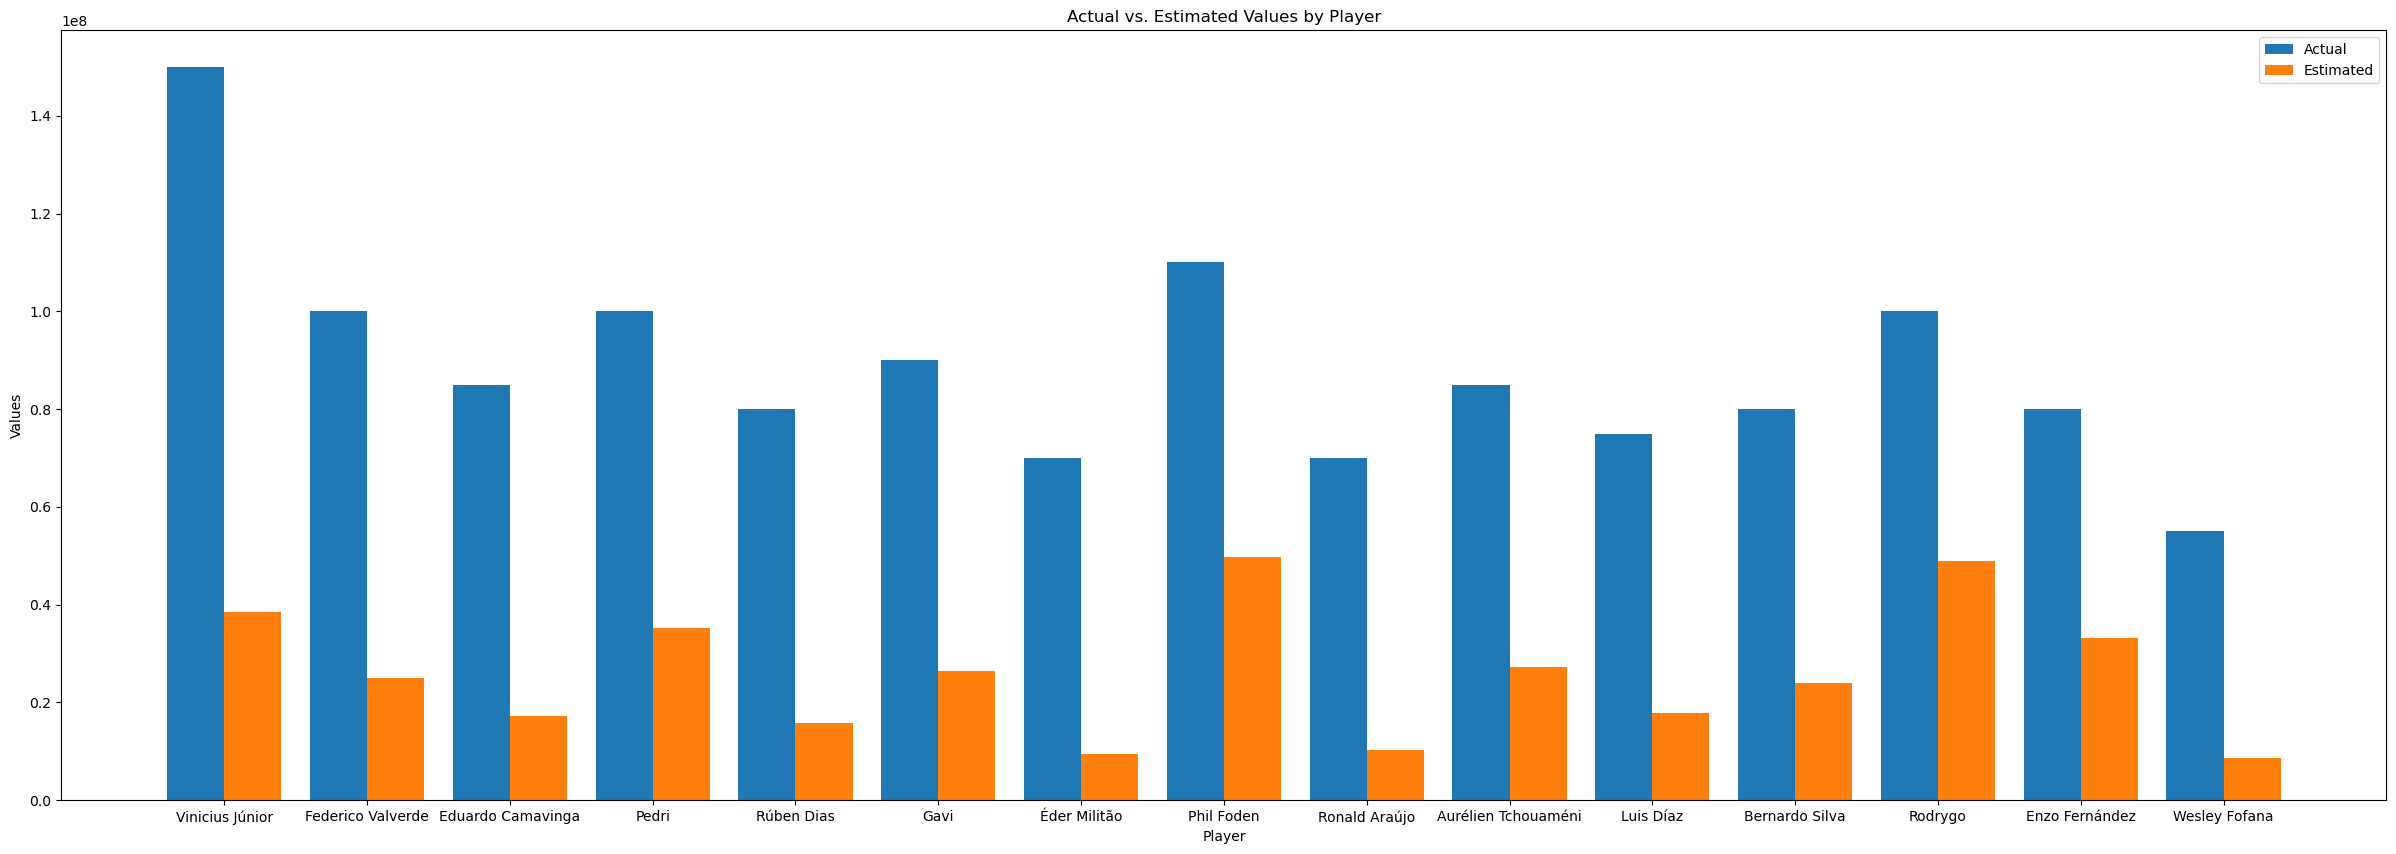

In [123]:
actual_values = overvalued_50.head(15)['value']
estimated_values = overvalued_50.head(15)['estimated_value']
labels = overvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels)  
plt.legend()

plt.show()

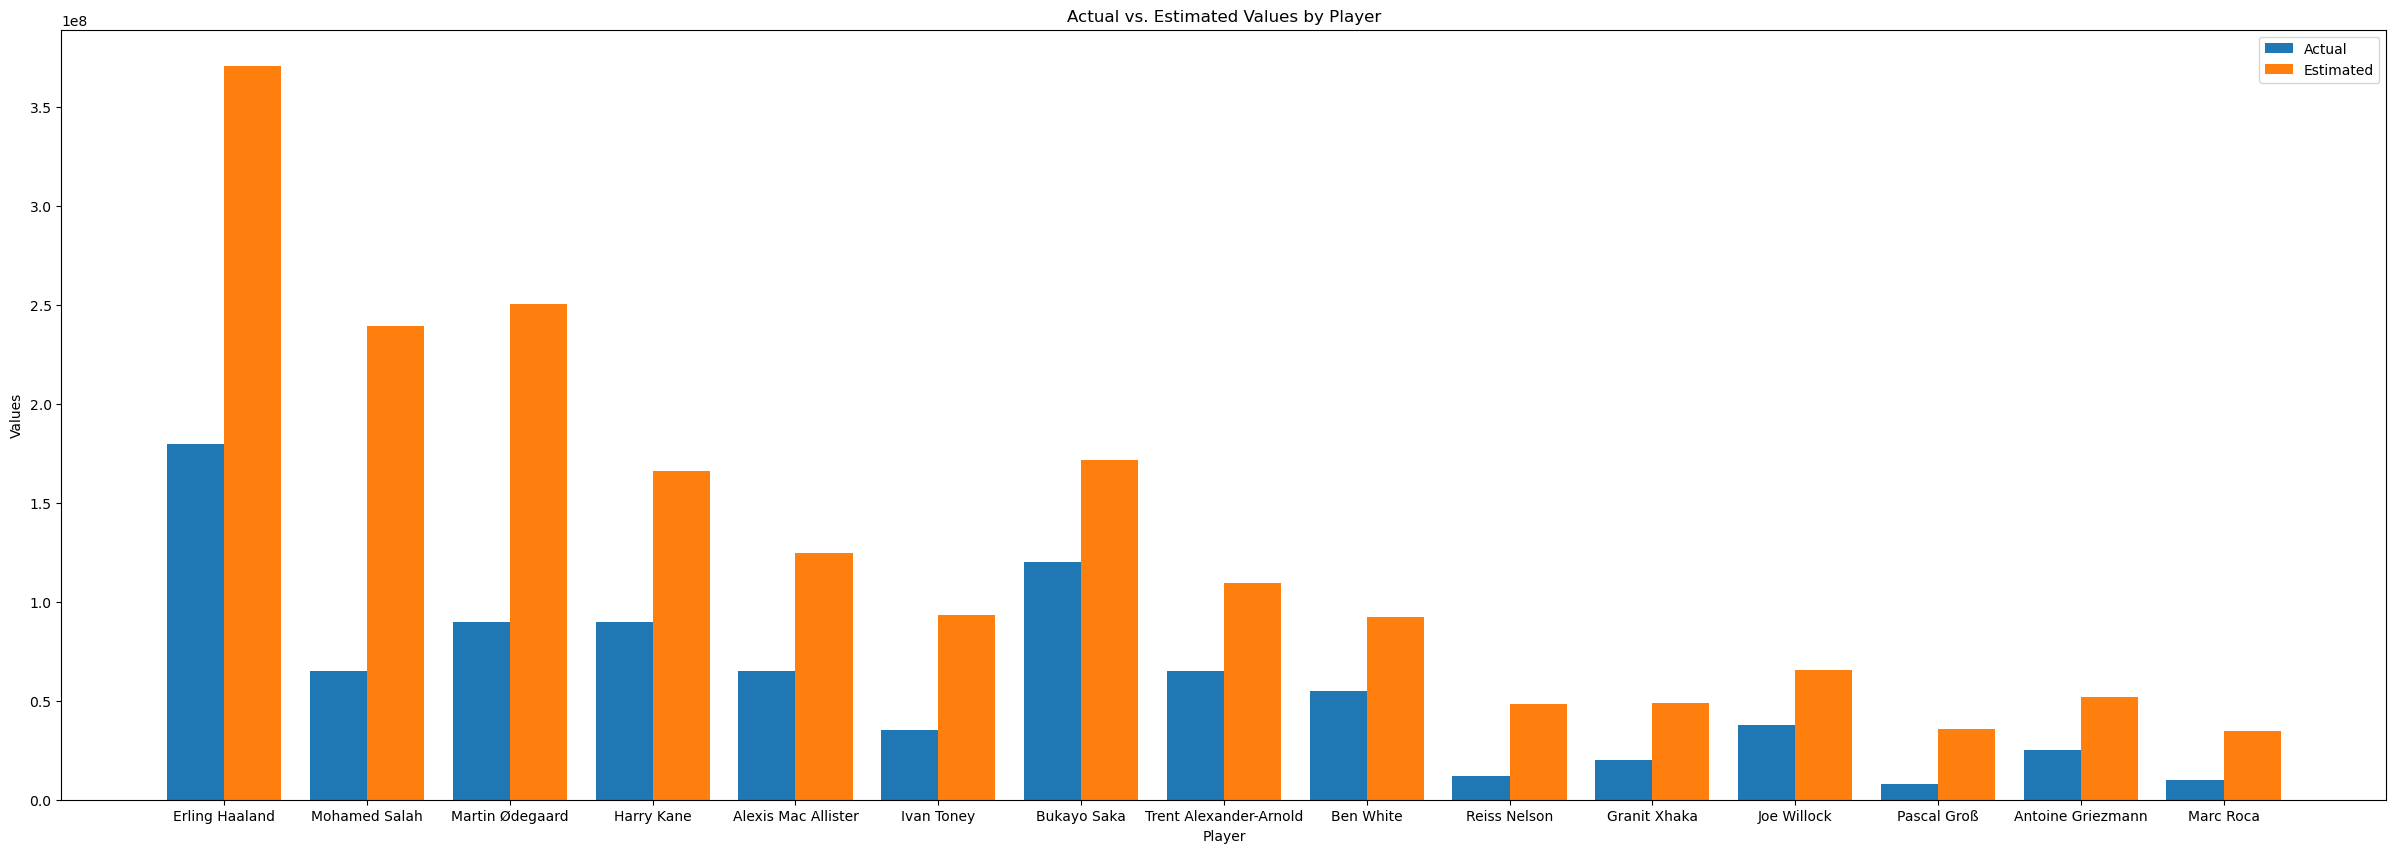

In [124]:
actual_values = undervalued_50.head(15)['value']
estimated_values = undervalued_50.head(15)['estimated_value']
labels = undervalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels)  
plt.legend()

plt.show()

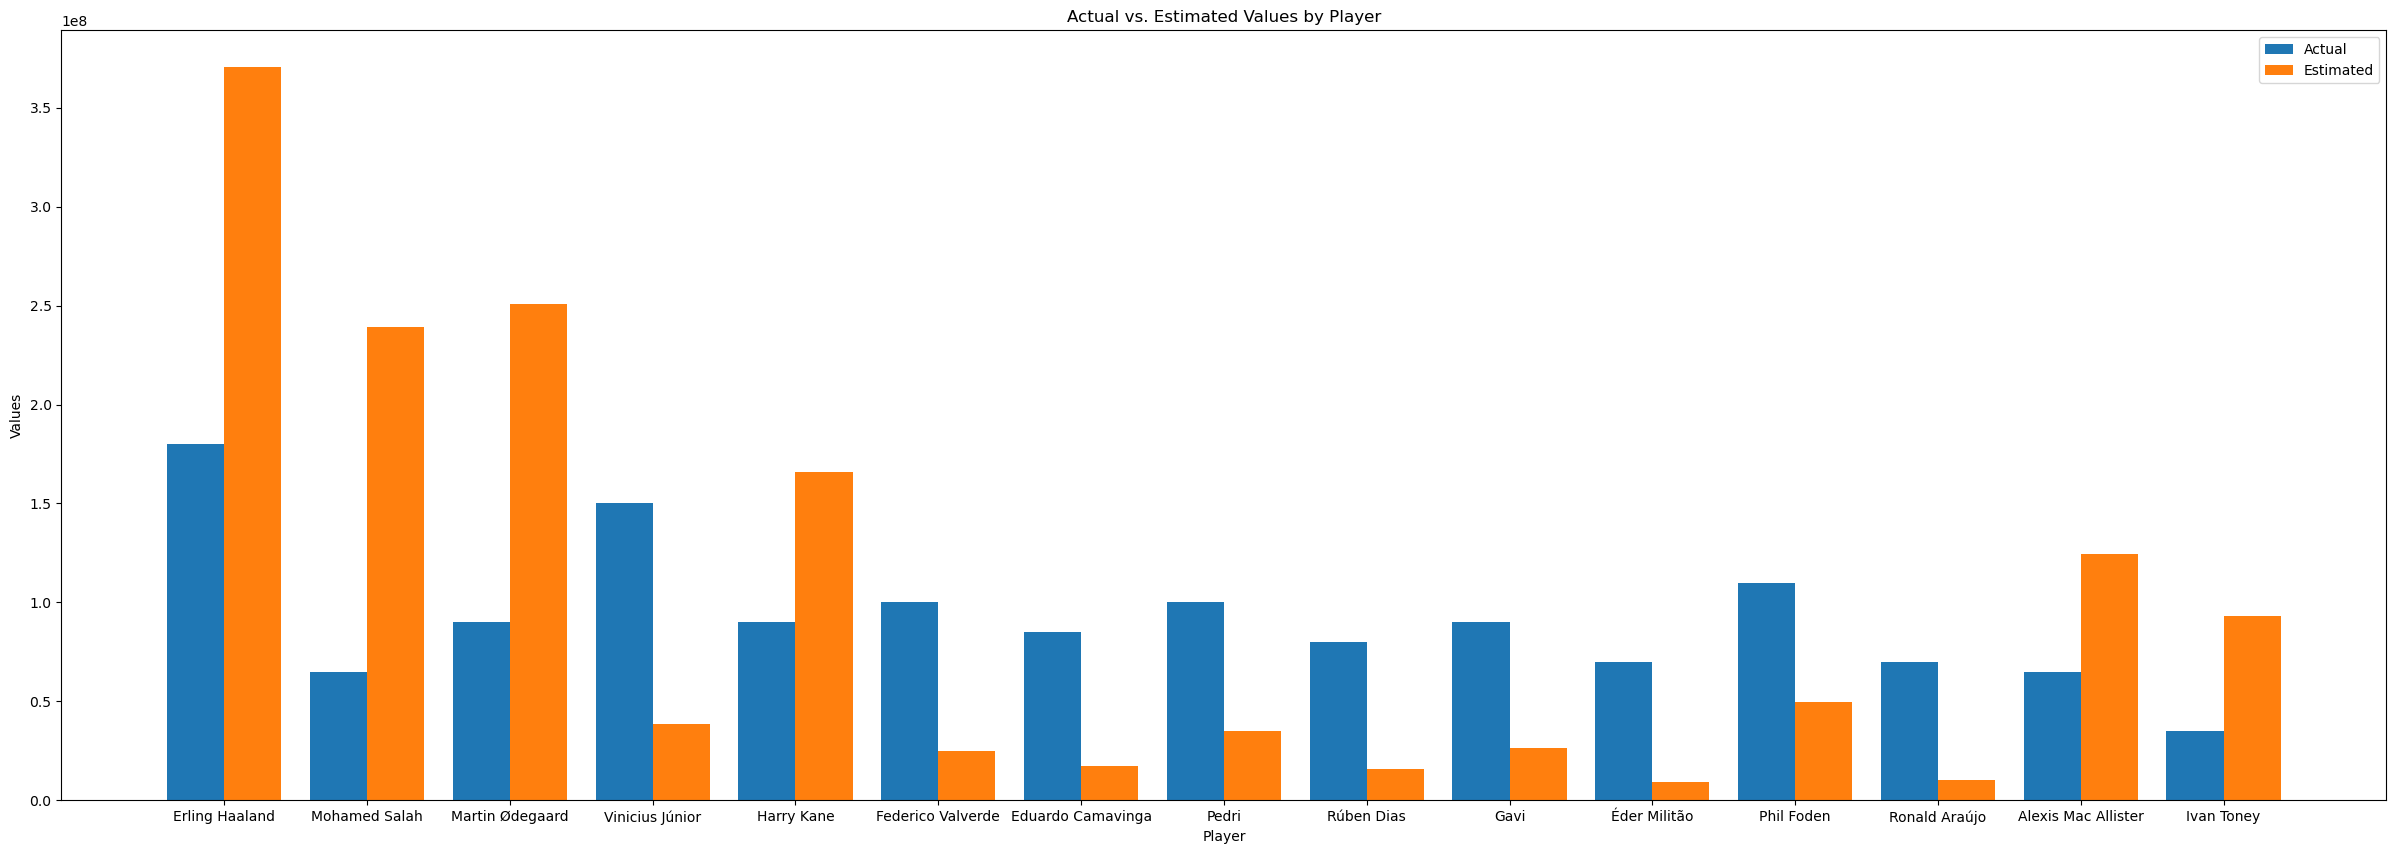

In [125]:
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels)  
plt.legend()

plt.show()

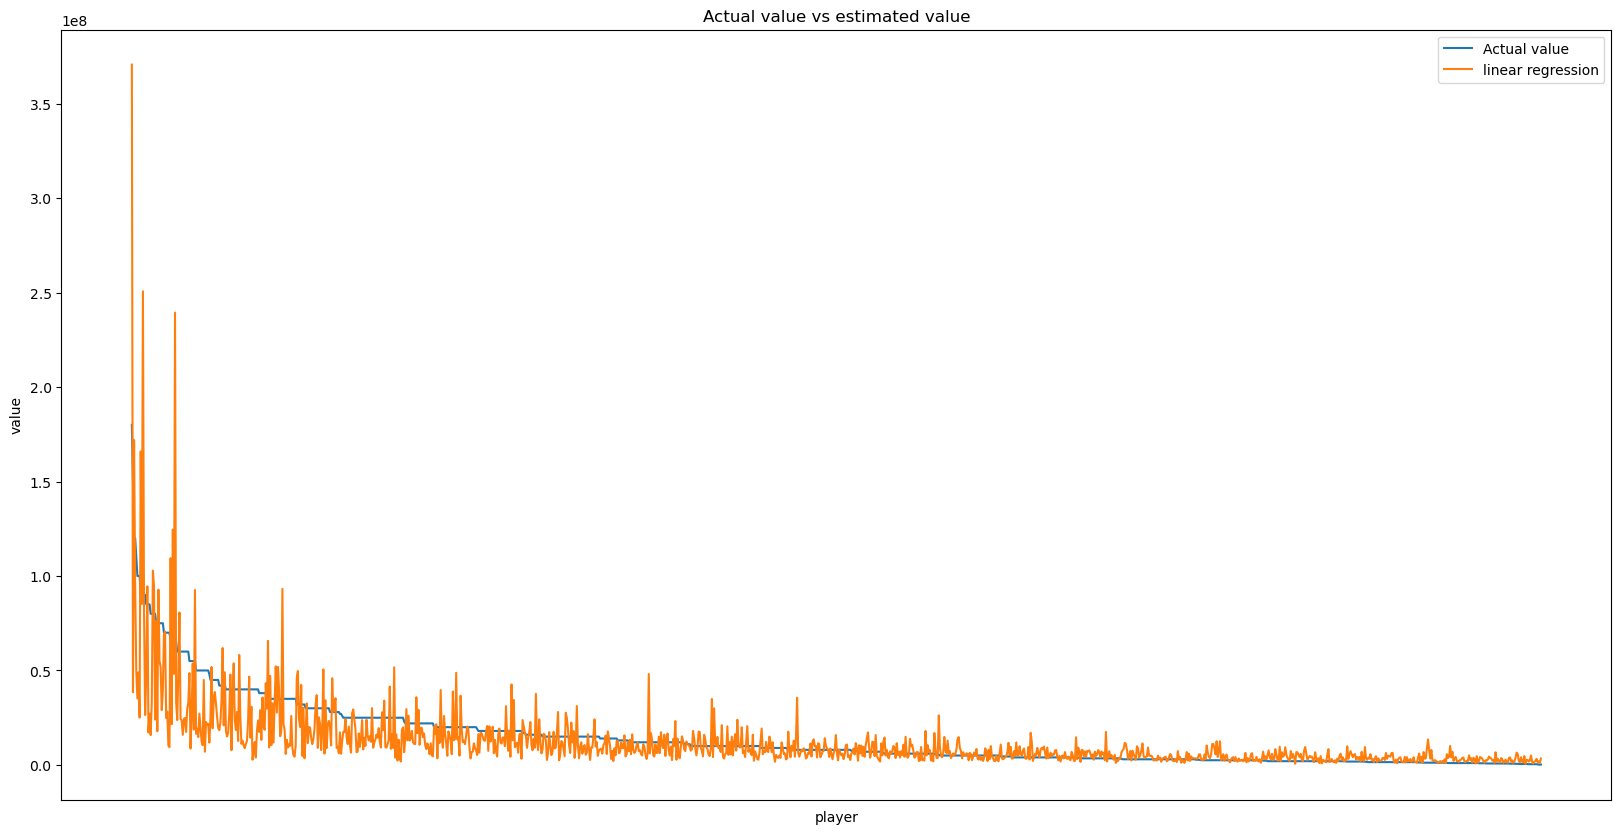

In [133]:

plt.figure(figsize=(20, 10))  
plt.xlabel('player')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label='Actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='linear regression')


plt.legend()
plt.show()

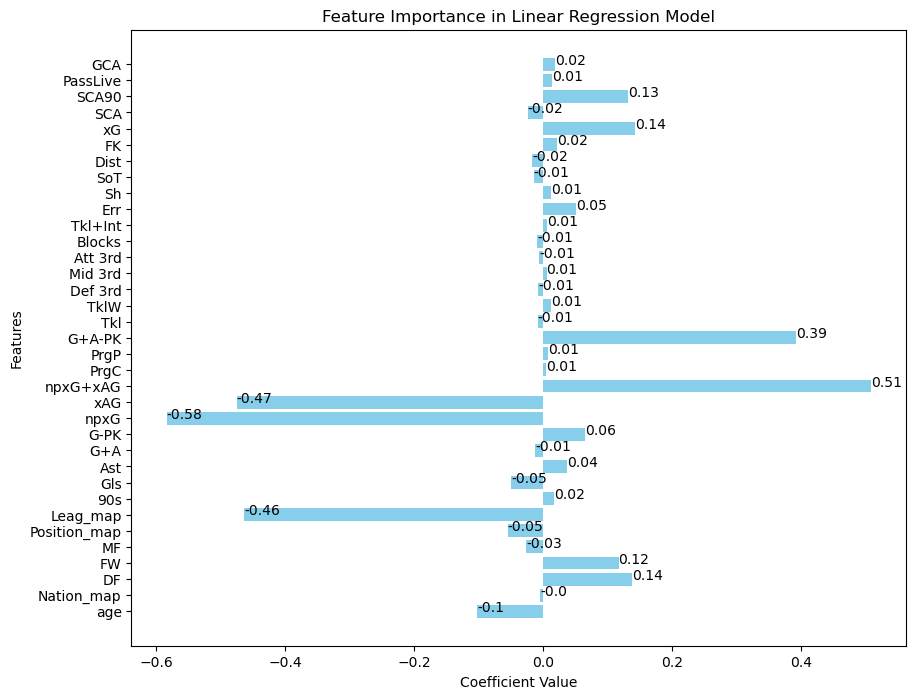

In [134]:

coefficients = model.coef_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures
# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Linear Regression Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [127]:
with open('E:/Inzynierka/model/linear_regression.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [128]:
coefficients = model.coef_
intercept = model.intercept_

# Creating the equation string
equation_terms = [f"{coef:.2f} * x{i+1}" for i, coef in enumerate(coefficients)]
equation = "y = " + " + ".join(equation_terms) + f" + {intercept:.2f}"

# Print the equation
print(equation)

y = -0.10 * x1 + -0.00 * x2 + 0.14 * x3 + 0.12 * x4 + -0.03 * x5 + -0.05 * x6 + -0.46 * x7 + 0.02 * x8 + -0.05 * x9 + 0.04 * x10 + -0.01 * x11 + 0.06 * x12 + -0.58 * x13 + -0.47 * x14 + 0.51 * x15 + 0.01 * x16 + 0.01 * x17 + 0.39 * x18 + -0.01 * x19 + 0.01 * x20 + -0.01 * x21 + 0.01 * x22 + -0.01 * x23 + -0.01 * x24 + 0.01 * x25 + 0.05 * x26 + 0.01 * x27 + -0.01 * x28 + -0.02 * x29 + 0.02 * x30 + 0.14 * x31 + -0.02 * x32 + 0.13 * x33 + 0.01 * x34 + 0.02 * x35 + 18.63


c:\Users\Jedrek\anaconda3\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


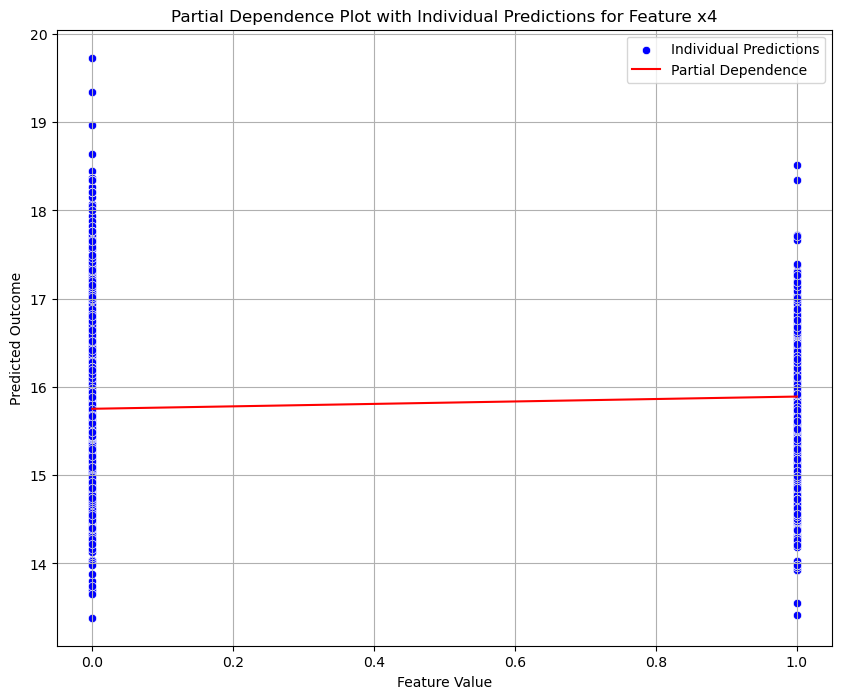

In [129]:
feature_index = 2  # Feature index (e.g., 0 for the first feature)

# Compute partial dependence values for the chosen feature
pd_results = partial_dependence(model, X_train_selected, features=[feature_index], kind="average")
values = pd_results["values"][0]
average_prediction = pd_results["average"][0].flatten()

# Create a DataFrame for plotting the partial dependence
pd_data = pd.DataFrame({
    'Feature Value': np.repeat(values, len(average_prediction) // len(values)),
    'Partial Dependence': average_prediction
})

# Predictions for each data point
individual_predictions = model.predict(X_train_selected)

# Create a DataFrame including individual data points
individual_data = pd.DataFrame({
    'Feature Value': X_train_selected[:, feature_index],
    'Individual Predictions': individual_predictions
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=individual_data, x='Feature Value', y='Individual Predictions', color='blue', label='Individual Predictions')
sns.lineplot(data=pd_data, x='Feature Value', y='Partial Dependence', color='red', label='Partial Dependence')
plt.title(f"Partial Dependence Plot with Individual Predictions for Feature x{feature_index + 2}")
plt.xlabel('Feature Value')
plt.ylabel('Predicted Outcome')
plt.legend()
plt.grid(True)
plt.show()